interesting stuff:
--
1. common in x, rare in z: stop words.
2. rel class distribution is different than x_norm class distribution: find a few explainable examples & give example sentence
3. False Analysis - what charactarizes the rationales with strong falses?
4. words that are especially common in the rationales: z_norm / x_norm

interesting figures:
--
1. rationale length (percent) distribution
2. rel distribution (without tiny words)



In [50]:
import numpy as np
import pandas as pd
import os
import os.path as osp
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# p = 'exp2_rationales.json'
p = r'C:\Users\Tomer\dev\university\NLP\repo\Project\Master-Thesis-master\exp\beer_cls\rationales.json'
df = pd.read_json(p, orient='records', lines=True)

# Read data

In [52]:
def list2array(x):
    if isinstance(x, list):
        return np.array(x)
    return x

def get_z_ids(row):
    x = np.array(row['x'])
    z = np.array(row['z'], dtype=bool)
    return x[z].tolist()

df = df.applymap(list2array)
df['y'] = df['y'].apply(lambda x: x[0])
df['z_ids'] = df.apply(get_z_ids, axis='columns')
df['pred_class'] = df['p_r'].apply(np.argmax)

In [53]:
d = pd.DataFrame(df['x'].apply(len))
d.columns = ['sentence lens']

with pd.option_context('display.max_rows', 6):
    display(d)

sentence lens
0               102
1               102
2               102
...             ...
9981            161
9982            161
9983            161

[9984 rows x 1 columns]

In [54]:
all_words = (' '.join(df['text'])).split(' ')
all_ids = np.hstack(df['x'])
vocab = pd.DataFrame()
vocab['word'] = all_words
vocab.index = all_ids
vocab.drop_duplicates(inplace=True)
vocab.sort_index(inplace=True)
vocab.index.name = 'word_id'

with pd.option_context('display.max_rows', 10):
    display(vocab)

word
word_id                
0                   the
1                     .
2                     a
3                     ,
4                    of
...                 ...
147108      smell-clean
147188   yonderwonderer
147395            1/can
147759            <unk>
147760        <padding>

[26904 rows x 1 columns]

In [55]:
vocab[vocab['word'] == 'tasty']

word
word_id       
379      tasty

# Rationales Sizes

In [56]:
z_percent = df['z'].apply(np.mean)
z_percent.hist(figsize=(8,6))
plt.tick_params(labelsize=14)
plt.title('Rationale Size Histogram', fontsize=16)
plt.xlabel('Percent of Entire Text', fontsize=16)
plt.ylabel('Num Samples', fontsize=16)
plt.show()

# rel class distribution

In [57]:
def get_value_counts(a):
    a = pd.Series(np.hstack(a))
    counts = a.value_counts()
    return counts

def get_relative_counts(df):
    g = df.groupby('y')
    x_counts = g['x'].apply(get_value_counts)
    z_counts = g['z_ids'].apply(get_value_counts)
    rel_counts = z_counts / x_counts
    rel_counts.fillna(0, inplace=True)
    return x_counts, z_counts, rel_counts

is_tp = df['pred_class'] == df['y']
df_tp = df[is_tp]
df_fp = df[~is_tp]

x_counts_tp, z_counts_tp, rel_counts_tp = get_relative_counts(df_tp)
x_counts_fp, z_counts_fp, rel_counts_fp = get_relative_counts(df_fp)
x_counts_all, z_counts_all, rel_counts_all = get_relative_counts(df)

In [58]:
x_counts, z_counts, rel_counts = x_counts_tp, z_counts_tp, rel_counts_tp

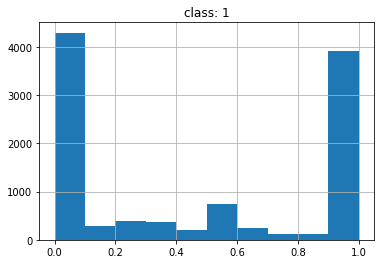

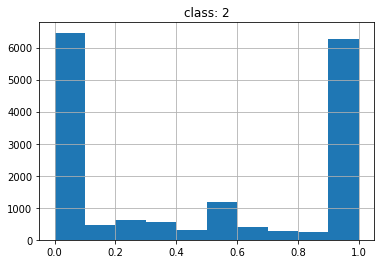

In [59]:
for i_cls in range(len(rel_counts.index.levels[0])):
    plt.figure()
    plt.title('class: ' + str(i_cls))
    rel_counts[i_cls].hist()


In [60]:
def to_by_class(rel):
    rel = pd.DataFrame(rel).unstack(level=0)
    rel.columns = rel.columns.droplevel()
    rel.columns.name = 'class'
    rel.index.name = 'word_id'
    rel.fillna(0, inplace=True)
    return rel

x_cls = to_by_class(x_counts)
z_cls = to_by_class(z_counts)
rel_cls = to_by_class(rel_counts)
stds = rel_cls.std(axis='columns')
x_cls_norm = x_cls / x_cls.sum(axis=0)
z_cls_norm = z_cls / z_cls.sum(axis=0)
norm_rel = (z_cls_norm / x_cls_norm).fillna(0)

In [61]:
x_norm_argsort = x_cls_norm.apply(np.argsort, axis=1)
rel_argsort = rel_cls.apply(np.argsort, axis=1)
not_same_order = (x_norm_argsort != rel_argsort).any(axis=1)

In [62]:
x_norm_argmax = x_cls_norm.apply(pd.Series.idxmax, axis=1)
rel_argmax = rel_cls.apply(pd.Series.idxmax, axis=1)
not_same_argmax = x_norm_argmax != rel_argmax

In [200]:
min_samples = 50
any_or_all = np.all
atleast = any_or_all(x_cls > min_samples, axis=1)

keep = atleast & not_same_argmax

std_inds = stds[keep].sort_values(ascending=False).index
different_words = vocab.loc[std_inds]

words = different_words['word'].iloc[:10]
# words = ['amazing', 'worst', 'dull', 'awesome']
# words = ['christmas', 'hot', 'somewhat', 'typical']  # min_samples=10

for word in words:
    word_id = vocab[vocab['word'] == word].index[0]
    print(word_id)

    print(word)
    for i_cls in range(z_cls.shape[1]):
        print(z_cls.loc[word_id, i_cls], '/', x_cls.loc[word_id, i_cls], '=', rel_cls.loc[word_id, i_cls])
    print('x_cls_norm:')
    print(pd.DataFrame(x_cls_norm.loc[word_id]).T)
    print()

574
hot
14.0 / 76.0 = 0.18421052631578946
19.0 / 65.0 = 0.2923076923076923
100.0 / 166.0 = 0.6024096385542169
x_cls_norm:
class         0         1         2
574    0.000388  0.000246  0.000269

637
let
19.0 / 62.0 = 0.3064516129032258
10.0 / 63.0 = 0.15873015873015872
12.0 / 213.0 = 0.056338028169014086
x_cls_norm:
class         0         1         2
637    0.000317  0.000239  0.000346

321
low
48.0 / 99.0 = 0.48484848484848486
78.0 / 110.0 = 0.7090909090909091
194.0 / 327.0 = 0.5932721712538226
x_cls_norm:
class         0         1        2
321    0.000506  0.000417  0.00053

342
somewhat
29.0 / 91.0 = 0.31868131868131866
56.0 / 109.0 = 0.5137614678899083
103.0 / 285.0 = 0.36140350877192984
x_cls_norm:
class         0         1         2
342    0.000465  0.000413  0.000462

310
drinking
26.0 / 145.0 = 0.1793103448275862
67.0 / 178.0 = 0.37640449438202245
87.0 / 286.0 = 0.3041958041958042
x_cls_norm:
class         0         1         2
310    0.000741  0.000674  0.000464

212
high
29.

In [222]:
thresh_all = 20
thresh_any = 50

atleast = (x_cls > thresh_all).all(axis=1) & (x_cls > thresh_any).any(axis=1)

i_cls = 2

# keep = atleast & not_same_argmax
keep = atleast & (rel_cls.idxmax(axis=1) == i_cls) & (stds > 0.05)

sort_inds = stds[keep].sort_values(ascending=False).index
# sort_inds = rel_cls[keep][i_cls].sort_values(ascending=False).index
different_words = vocab.loc[sort_inds]

words = different_words['word'].iloc[:50]
# words = ['amazing', 'worst', 'dull', 'awesome']
# words = ['christmas', 'hot', 'somewhat', 'typical']  # min_samples=10

for word in words:
    word_id = vocab[vocab['word'] == word].index[0]
    print(word_id)

    print(word)
    for i_cls in range(z_cls.shape[1]):
        print(z_cls.loc[word_id, i_cls], '/', x_cls.loc[word_id, i_cls], '=', rel_cls.loc[word_id, i_cls])
    print('std =', stds.loc[word_id])
    print()

574
hot
14.0 / 76.0 = 0.18421052631578946
19.0 / 65.0 = 0.2923076923076923
100.0 / 166.0 = 0.6024096385542169
std = 0.2170786001422727

522
green
26.0 / 91.0 = 0.2857142857142857
27.0 / 45.0 = 0.6
80.0 / 122.0 = 0.6557377049180327
std = 0.1994991782409321

667
case
10.0 / 31.0 = 0.3225806451612903
1.0 / 23.0 = 0.043478260869565216
21.0 / 56.0 = 0.375
std = 0.17820989179200108

389
huge
8.0 / 39.0 = 0.20512820512820512
39.0 / 104.0 = 0.375
198.0 / 359.0 = 0.5515320334261838
std = 0.17321258507878115

671
super
9.0 / 30.0 = 0.3
30.0 / 55.0 = 0.5454545454545454
71.0 / 114.0 = 0.6228070175438597
std = 0.16854065256300796

1038
sitting
0.0 / 25.0 = 0.0
7.0 / 29.0 = 0.2413793103448276
28.0 / 93.0 = 0.3010752688172043
std = 0.159412408767235

1174
brewing
4.0 / 23.0 = 0.17391304347826086
5.0 / 22.0 = 0.22727272727272727
23.0 / 53.0 = 0.4339622641509434
std = 0.13735199166256895

886
crystal
2.0 / 32.0 = 0.0625
11.0 / 47.0 = 0.23404255319148937
21.0 / 68.0 = 0.3088235294117647
std = 0.12628956

# Variable Explanations

In [64]:
print('x_cls: how many text appearances for each word?')
with pd.option_context('display.max_rows',6):
    display(x_cls)

x_cls: how many text appearances for each word?


class          0        1        2
word_id                           
0         6498.0   9531.0  23870.0
1        13225.0  18160.0  40984.0
2         7298.0  11077.0  24227.0
...          ...      ...      ...
147188       0.0      0.0      2.0
147759     604.0    665.0   1467.0
147760    3831.0   4947.0  10165.0

[22786 rows x 3 columns]

In [65]:
print('x_cls: how many rationale appearances for each word?')
with pd.option_context('display.max_rows',6):
    display(z_cls)

x_cls: how many rationale appearances for each word?


class         0       1       2
word_id                        
0           2.0     3.0    15.0
1        2647.0  4117.0  9203.0
2           0.0     0.0     2.0
...         ...     ...     ...
147188      0.0     0.0     1.0
147759    317.0   339.0   727.0
147760    315.0   354.0   840.0

[14622 rows x 3 columns]

In [66]:
print('rel_cls: num_in_rationale / num_in_text')
with pd.option_context('display.max_rows',6):
    display(rel_cls)

rel_cls: num_in_rationale / num_in_text


class           0         1         2
word_id                              
0        0.000308  0.000315  0.000628
1        0.200151  0.226707  0.224551
2        0.000000  0.000000  0.000083
...           ...       ...       ...
147188   0.000000  0.000000  0.500000
147759   0.524834  0.509774  0.495569
147760   0.082224  0.071559  0.082636

[22786 rows x 3 columns]

In [67]:
print('stds: std(rel_cls). how different beween classes?')
with pd.option_context('display.max_rows',6):
    display(stds)

stds: std(rel_cls). how different beween classes?


word_id
0         0.000183
1         0.014749
2         0.000048
            ...   
147188    0.288675
147759    0.014635
147760    0.006280
Length: 22786, dtype: float64

In [68]:
print('x_cls_norm: word occurence in entire text corpus\n3.3% of the words in class 0 are the word with id 0, which is "the".')
with pd.option_context('display.max_rows',6):
    display(x_cls_norm)

x_cls_norm: word occurence in entire text corpus
3.3% of the words in class 0 are the word with id 0, which is "the".


class           0         1         2
word_id                              
0        0.033193  0.036102  0.038720
1        0.067555  0.068787  0.066481
2        0.037279  0.041958  0.039299
...           ...       ...       ...
147188   0.000000  0.000000  0.000003
147759   0.003085  0.002519  0.002380
147760   0.019569  0.018738  0.016489

[22786 rows x 3 columns]

In [69]:
print('z_cls_norm: word occurence in entire rationale corpus\n0.004% of the words in class 0 are the word with id 0, which is "the".')
with pd.option_context('display.max_rows',6):
    display(z_cls_norm)

z_cls_norm: word occurence in entire rationale corpus
0.004% of the words in class 0 are the word with id 0, which is "the".


class           0         1         2
word_id                              
0        0.000040  0.000040  0.000083
1        0.053226  0.054481  0.050980
2        0.000000  0.000000  0.000011
...           ...       ...       ...
147188   0.000000  0.000000  0.000006
147759   0.006374  0.004486  0.004027
147760   0.006334  0.004685  0.004653

[14622 rows x 3 columns]

In [70]:
print('norm_rel: occurence_in_z / occurence in x.\nlarger than 1 --> words are more prominent in the rationales than they are in the text.')
with pd.option_context('display.max_rows',6):
    display(norm_rel)

norm_rel: occurence_in_z / occurence in x.
larger than 1 --> words are more prominent in the rationales than they are in the text.


class           0         1         2
word_id                              
0        0.001212  0.001100  0.002146
1        0.787899  0.792017  0.766839
2        0.000000  0.000000  0.000282
...           ...       ...       ...
147188   0.000000  0.000000  1.707494
147759   2.066020  1.780932  1.692363
147760   0.323676  0.249995  0.282203

[22786 rows x 3 columns]

# word significance

In [194]:
# min_samples = 20
# any_or_all = np.all
# atleast = any_or_all(x_cls > min_samples, axis=1)

# significat_in_z = norm_rel[atleast].max(axis=1).sort_values(ascending=False).index

# significat_in_z = ((z_cls.sum(axis=1) / z_cls.values.sum()) /
#                    (x_cls.sum(axis=1) / x_cls.values.sum())).sort_values(ascending=False).index

min_samples = 20
atleast = (x_cls > min_samples).all(axis=1)
significat_in_z = z_cls.index[(x_cls.loc[z_cls.index] == z_cls).all(axis=1)].intersection(atleast.index[atleast])
significat_in_z = x_cls.sum(axis=1).loc[significat_in_z].sort_values(ascending=False).index

sig_words = vocab.loc[significat_in_z]
with pd.option_context('display.max_rows',6):
    display(norm_rel.loc[significat_in_z])
    display(sig_words)

class           0         1         2
word_id                              
74       3.936518  3.493569  3.414988
54       3.936518  3.493569  3.414988
63       3.936518  3.493569  3.414988
...           ...       ...       ...
1206     3.936518  3.493569  3.414988
1606     3.936518  3.493569  3.414988
875      3.936518  3.493569  3.414988

[56 rows x 3 columns]

word
word_id        
74        smell
54        sweet
63        aroma
...         ...
1206      musty
1606      whiff
875      mildly

[56 rows x 1 columns]

In [195]:
merged = pd.merge(x_cls, z_cls, left_index=True, right_index=True, how='outer', suffixes=('_x', '_z')).fillna(0)
sig = merged.loc[significat_in_z]
sig['word'] = sig_words
with pd.option_context('display.max_rows',10):
    display(sig)


class      0_x     1_x     2_x    0_z     1_z     2_z        word
word_id                                                          
74       975.0   899.0  2164.0  975.0   899.0  2164.0       smell
54       422.0   793.0  2260.0  422.0   793.0  2260.0       sweet
63       533.0   757.0  2056.0  533.0   757.0  2056.0       aroma
51       448.0   976.0  1857.0  448.0   976.0  1857.0        hops
49       574.0  1079.0  1624.0  574.0  1079.0  1624.0        malt
...        ...     ...     ...    ...     ...     ...         ...
1218      28.0    23.0   102.0   28.0    23.0   102.0  astringent
794       36.0    33.0    68.0   36.0    33.0    68.0       grass
1206      23.0    41.0    50.0   23.0    41.0    50.0       musty
1606      31.0    26.0    56.0   31.0    26.0    56.0       whiff
875       28.0    30.0    47.0   28.0    30.0    47.0      mildly

[56 rows x 7 columns]

In [199]:
d = pd.DataFrame(sig_words.values.reshape(8, 7))
d.to_csv('significant_in_entire_dataset.csv')
# d.columns = pd.MultiIndex.from_product([['significant words (all classes)'], d.index]

In [129]:
norm_rel

class           0         1         2
word_id                              
0        0.001212  0.001100  0.002146
1        0.787899  0.792017  0.766839
2        0.000000  0.000000  0.000282
3        0.633657  0.794084  0.972220
4        0.020302  0.045977  0.036032
5        0.007170  0.023077  0.024689
6        0.016044  0.018051  0.006479
7        0.000000  0.000000  0.001747
8        0.013853  0.008723  0.011727
9        0.006650  0.017468  0.013511
10       0.007213  0.022455  0.042321
11       0.002199  0.001944  0.003926
12       0.006319  0.010866  0.012500
13       0.787304  0.000000  0.085375
14       0.000000  0.000000  0.000456
15       0.000000  0.000000  0.000000
16       0.000000  0.003527  0.001467
17       0.000000  0.001386  0.003404
18       0.000000  0.000000  0.000000
19       0.000000  0.000000  0.000938
20       0.000000  0.000000  0.000000
21       0.005849  0.014557  0.013264
22       1.286862  1.342672  1.204329
23       0.024888  0.018160  0.010804
24       0.010917  0.019206  0.013535
25       0.333901  0.432654  0.475968
26       1.030030  0.975076  0.906996
27       1.414635  1.181292  1.176394
28       0.000000  0.085209  0.000000
29       0.000000  0.000000  0.000000
...           ...       ...       ...
145203   0.000000  0.000000  0.000000
145290   0.000000  0.000000  0.000000
145297   0.000000  0.000000  0.000000
145457   0.000000  0.000000  3.414988
145512   0.000000  0.000000  3.414988
145532   0.000000  3.493569  0.000000
145758   0.000000  3.493569  0.000000
145762   0.000000  0.000000  3.414988
145764   0.000000  0.000000  0.000000
145771   0.000000  0.000000  0.000000
145855   0.000000  0.000000  3.414988
145885   0.000000  3.493569  0.000000
146142   0.000000  0.000000  0.000000
146163   0.000000  0.000000  0.000000
146308   0.000000  0.000000  0.000000
146318   3.936518  0.000000  0.000000
146440   0.000000  0.000000  0.000000
146454   0.000000  0.000000  0.000000
146618   0.000000  3.493569  0.000000
146674   0.000000  0.000000  3.414988
146682   0.000000  0.000000  0.000000
146749   0.000000  0.000000  0.000000
146771   0.000000  0.000000  0.000000
146804   0.000000  0.000000  0.000000
146884   0.000000  0.000000  0.000000
146890   0.000000  0.000000  3.414988
147108   3.936518  0.000000  0.000000
147188   0.000000  0.000000  1.707494
147759   2.066020  1.780932  1.692363
147760   0.323676  0.249995  0.282203

[22786 rows x 3 columns]

In [151]:
sig0 = vocab.loc[norm_rel.loc[atleast, 0].sort_values(ascending=False).index]
sig1 = vocab.loc[norm_rel.loc[atleast, 1].sort_values(ascending=False).index]
sig2 = vocab.loc[norm_rel.loc[atleast, 2].sort_values(ascending=False).index]

s0 = set(sig0['word'][:200]) - set(sig1['word'][:200]) - set(sig2['word'][:200])
s1 = set(sig1['word'][:200]) - set(sig2['word'][:200]) - set(sig0['word'][:200])
s2 = set(sig2['word'][:200]) - set(sig1['word'][:200]) - set(sig0['word'][:200])

print('significant only for 0:\n', s0, '\n')
print('significant only for 1:\n', s1, '\n')
print('significant only for 2:\n', s2, '\n')

d = pd.DataFrame(np.array((list(s0) + ['']*9)[:9]).reshape(3,3))
d.columns = pd.MultiIndex.from_product([['significant only for 0'], d.index])
display(d)

d = pd.DataFrame(np.array((list(s1) + ['']*9)[:9]).reshape(3,3))
d.columns = pd.MultiIndex.from_product([['significant only for 1'], d.index])
display(d)

d = pd.DataFrame(np.array((list(s2) + ['']*9)[:9]).reshape(3,3))
d.columns = pd.MultiIndex.from_product([['significant only for 2'], d.index])
display(d)


significant only for 0:
 {'barely', 'extra', 'end', 'fine', 'place', 'again', 'presence', 'oz', 'brews', 'mouth'} 

significant only for 1:
 {'balance', 'extremely', 'present', 'summer', 'somewhat', 'typical', 'night'} 

significant only for 2:
 {'&', 'huge', 'cold', 'hot', 'great', 'date', 'dark', 'fast', 'tulip', 'lingers', 'throughout'} 



significant only for 0              
                       0      1      2
0                 barely  extra    end
1                   fine  place  again
2               presence     oz  brews

significant only for 1                    
                       0          1        2
0                balance  extremely  present
1                 summer   somewhat  typical
2                  night

significant only for 2              
                       0      1      2
0                      &   huge   cold
1                    hot  great   date
2                   dark   fast  tulip

In [48]:
# 1012 = odd

thresh_all = 5
thresh_any = 50

atleast = (z_cls >= thresh_all).all(axis=1) & (z_cls >= thresh_any).any(axis=1)
atleast = atleast.index[atleast.values.nonzero()]
norm_rel_atleast = norm_rel.loc[atleast]

classes = np.arange(3)
for i_cls in classes:
    curr_norm_rel = norm_rel_atleast[i_cls]
    min_other_norm_rel = norm_rel_atleast[np.setdiff1d(classes, [i_cls])].min(axis=1)
    max_other_norm_rel = norm_rel_atleast[np.setdiff1d(classes, [i_cls])].max(axis=1)

    sig_vs_min = curr_norm_rel / (min_other_norm_rel + 1e-5)
    sig_vs_min.sort_values(ascending=False, inplace=True)
    sig_vs_min = pd.DataFrame(sig_vs_min)
    sig_vs_min['word'] = vocab

    sig_vs_max = curr_norm_rel / (max_other_norm_rel + 1e-5)
    sig_vs_max.sort_values(ascending=False, inplace=True)
    sig_vs_max = pd.DataFrame(sig_vs_max)
    sig_vs_max['word'] = vocab
    
    sig_vs = pd.merge(sig_vs_max.reset_index(), sig_vs_min.reset_index(), left_index=True, right_index=True, suffixes=('_vs_max', '_vs_min'))

    print('sig_vs, cls %d:' % i_cls)
    with pd.option_context('display.max_rows', 30):
        display(sig_vs)


sig_vs, cls 0:


word_id_vs_max  0_vs_max word_vs_max  word_id_vs_min  0_vs_min  \
0               294  2.144313   something             165  2.796400   
1               165  1.986825         off             164  2.729194   
2               164  1.910978       still              84  2.608222   
3                78  1.560999         you             294  2.503516   
4               112  1.518581         can             334  2.151095   
5               192  1.482870      around             192  1.926005   
6               214  1.477236        deep              78  1.914568   
7                84  1.471927          no             283  1.809642   
8               334  1.449440         say             677  1.784076   
9               419  1.448359        fine             214  1.676454   
10               76  1.446700      bottle             499  1.642989   
11               69  1.424261          up              69  1.618246   
12             1209  1.416553        burn             646  1.609691   
13              283  1.407605      fairly             419  1.606487   
14              265  1.404842     nothing             112  1.594186   
..              ...       ...         ...             ...       ...   
459             159  0.636572         big             233  0.734309   
460             212  0.624964        high             433  0.729537   
461             299  0.620788        your              68  0.721741   
462              68  0.616903         out             574  0.710089   
463            1081  0.558439  absolutely             573  0.688590   
464             671  0.555250       super             418  0.686553   
465             504  0.538897      bright             310  0.679471   
466             310  0.536772    drinking            1081  0.636087   
467             418  0.511696          --             671  0.619731   
468             522  0.502254       green             389  0.616359   
469               4  0.441482          of             504  0.595400   
470             121  0.439088       quite               4  0.563295   
471             389  0.428722        huge             522  0.536564   
472             574  0.352487         hot             121  0.450142   
473               5  0.290311         and               5  0.310585   

    word_vs_min  
0           off  
1         still  
2            no  
3     something  
4           say  
5        around  
6           you  
7        fairly  
8          wood  
9          deep  
10       either  
11           up  
12   complexity  
13         fine  
14          can  
..          ...  
459        rich  
460     perfect  
461         out  
462         hot  
463         cap  
464          --  
465    drinking  
466  absolutely  
467       super  
468        huge  
469      bright  
470          of  
471       green  
472       quite  
473         and  

[474 rows x 6 columns]

sig_vs, cls 1:


word_id_vs_max  0_vs_max word_vs_max  word_id_vs_min  0_vs_min  \
0               342  1.430733    somewhat               5  3.213854   
1               223  1.352178           ?             121  2.277247   
2               449  1.283439       thing               4  2.263489   
3                 4  1.275639          of             522  1.863685   
4               310  1.265836    drinking             310  1.862946   
5               290  1.260882        pour             504  1.855614   
6               163  1.239875       clear              84  1.771957   
7               212  1.235574        high              65  1.752161   
8                33  1.229254        some              33  1.642620   
9               186  1.228803        full             389  1.622398   
10              321  1.222717         low              68  1.620901   
11              548  1.203557   extremely             671  1.613580   
12              721  1.195884      bubbly             212  1.600064   
13              488  1.178444      behind            1081  1.572084   
14               68  1.169915         out             186  1.538714   
..              ...       ...         ...             ...       ...   
459             112  0.627256         can             502  0.793922   
460             419  0.622468        fine             398  0.793402   
461             646  0.621232  complexity             677  0.786303   
462              64  0.615723          my             238  0.784799   
463             214  0.596485        deep             545  0.770659   
464              87  0.593175       white             646  0.769891   
465             521  0.565443        date             211  0.764764   
466             677  0.560510        wood            1850  0.764445   
467              78  0.522241         you              64  0.727694   
468             211  0.510106        best             264  0.727467   
469             574  0.496394         hot             165  0.710479   
470             334  0.464864         say             164  0.700162   
471             294  0.399422   something              87  0.696224   
472             164  0.366383       still             334  0.673799   
473             165  0.357593         off             521  0.633654   

    word_vs_min  
0           and  
1         quite  
2            of  
3         green  
4      drinking  
5        bright  
6            no  
7        little  
8          some  
9          huge  
10          out  
11        super  
12         high  
13   absolutely  
14         full  
..          ...  
459       tulip  
460        note  
461        wood  
462         bad  
463        wine  
464  complexity  
465        best  
466       cider  
467          my  
468      enough  
469         off  
470       still  
471       white  
472         say  
473        date  

[474 rows x 6 columns]

sig_vs, cls 2:


word_id_vs_max  0_vs_max word_vs_max  word_id_vs_min  0_vs_min  \
0               574  2.014500         hot               5  3.438393   
1               211  1.499211        best             574  2.836928   
2               299  1.476652        your             389  2.332474   
3               389  1.437659        huge             121  2.221324   
4               418  1.341701          --             522  1.991000   
5               108  1.288236       other             211  1.960316   
6               381  1.287872        less             418  1.954202   
7               255  1.282213        long             671  1.800966   
8               144  1.234643       black            1081  1.790673   
9                 3  1.224314           ,               4  1.773904   
10              680  1.209961     reminds             521  1.768498   
11               47  1.205093        like              87  1.685733   
12               97  1.200434       great             504  1.679514   
13              159  1.199091         big              64  1.623978   
14              642  1.197749     lingers             299  1.610804   
..              ...       ...         ...             ...       ...   
459             112  0.658486         can            1008  0.809289   
460             630  0.654489      unique              62  0.800383   
461             186  0.649881        full             186  0.798582   
462             168  0.645495         any             499  0.794870   
463              78  0.640540         you             127  0.788391   
464              69  0.617922          up             623  0.784615   
465              33  0.608752        some              56  0.782047   
466             499  0.608641      either             726  0.779454   
467              65  0.570709      little             660  0.777951   
468             283  0.552587      fairly             283  0.777828   
469             164  0.523263       still             192  0.769901   
470             192  0.519190      around              33  0.748326   
471             165  0.503304         off             330  0.731034   
472             294  0.466333   something              65  0.632714   
473              84  0.383392          no              84  0.564329   

    word_vs_min  
0           and  
1           hot  
2          huge  
3         quite  
4         green  
5          best  
6            --  
7         super  
8    absolutely  
9            of  
10         date  
11        white  
12       bright  
13           my  
14         your  
..          ...  
459         tad  
460         n't  
461        full  
462      either  
463    slightly  
464      tasted  
465         bit  
466       fizzy  
467         hue  
468      fairly  
469      around  
470        some  
471         day  
472      little  
473          no  

[474 rows x 6 columns]

# Playground

In [120]:
word = 'hot'
word_id = vocab[vocab['word'] == word].index[0]
df_word = df[df['z_ids'].apply(lambda x: word_id in x)]
is_cls = (df_word['y'] == 2) & (df_word['y'] == df_word['pred_class'])
df_word = df_word[is_cls]

short_rationales = df_word['rationale'].apply(lambda s: s.replace('__ ', ''))
start = df_word['z_ids'].apply(lambda x: max(np.nonzero(x == word_id)[0][0]-0, 0))

hot_rationales = []
for i in short_rationales.index:
    hot_rat = ' '.join(np.hstack(vocab.loc[df.loc[i, 'z_ids'][start.loc[i] : start.loc[i] + 7]].values))
    hot_rationales.append(hot_rat)
    print(hot_rat)

with open('hot_rationales.txt', 'w') as f:
    f.write('\n'.join(hot_rationales))

hot fudge sundae match float dessert
hot ! hmmm ... yeah right hot
hot chocolate t smell initial twinge stout
hot drinking brew halls
hot cocoa almost . taste- kinda smokey
hot cider ... t- smell great apple/pear
hot ashy end <unk> beer goes
hot taste alcohol abv m medium bodied
hot again aging
hot toddy honey slight bourbon flavor mix
hot m body low carbonation high abv
hot hoppy sweet incredibly bitter . hop
hot spiced tea lovely scents taste .
hot liking 11 hidden future impress
hot
hot thing mellow out monster
hot your nose dallop caramelized sugar heaping
hot '' out-of-balance alcohol flavor high phenolic
hot finish abv place
hot alcohol tinge organic ale dubbel respectable
hot . m- dry bitter boozy
hot alcohol burn any taste away decent
hot pretzles good
hot mess . slap style general alright
hot . bit ok wild aquired taste
hot . touch sweetness nice caramel+toffee way
hot booziest tried malty sickly sweet ,
hot touches espresso , coffee dark burnt
hot caramel . finish dry pleasan

35       8
186     13
250     14
260     47
262     51
287     16
296     35
300     13
309     20
327     33
339     58
352     40
695     20
747      0
822      0
828     29
1139    26
1257    44
1364    24
1392    14
1493    43
1722    15
1877    22
1921    28
1922    19
1928    53
2016    37
2137     6
2238    20
2256    14
        ..
8051     0
8068    21
8126    48
8129    73
8135    28
8176    47
8188    12
8267     4
8270    55
8290    58
8332    64
8339    78
8342    58
8354    19
8368    60
8371     0
8434    39
8439    55
8776    17
8802     9
8987    32
9244    48
9389    13
9443    28
9484    16
9510    14
9561    18
9568    27
9933    41
9974    52
Name: z_ids, Length: 162, dtype: int64

In [28]:
df['text'].iloc[-1]

"a - coppery liquid with a slight haze and only a ring of foam on the edge of the glass . s - strong with molasses and maple ; a touch of sherry notes . t - sweet up front , with a touch of spice on the back end ; strong alcohol presence early but softens as beer warms ; alcohol up front in the taste ; also , caramel , raisins , anise and a little pepper ; soft bitterness in the finish . m - very long finish with a lot of alcohol warmth . lush body and kind of creamy . d - not something i could session , but drinking two in a sitting is doable not my absolute favorite beer , but definitely good . ca n't quite put a finger on what 's missing , but it 's just not something i could n't live without . overall , a very fine brew ."

In [29]:
np.hstack(df['z']).mean()

0.28098917895962733

In [30]:
with pd.option_context('display.max_rows', 6):
    display(df['z'].apply(np.mean))

0       0.411765
1       0.245098
2       0.284314
          ...   
9981    0.304348
9982    0.149068
9983    0.298137
Name: z, Length: 9984, dtype: float64

In [31]:
np.median(df['z'].apply(np.mean))

0.28125

In [32]:
is_all = df['z'].apply(np.all)
not_all = df.loc[~is_all]

In [33]:
np.median(not_all['z'].apply(np.mean))

0.28125

In [34]:
np.mean(np.hstack(not_all['z']))

0.28098917895962733

In [35]:
def pads_in_rationale(row, padding_id=400001):
    return np.mean(row['z'][row['x'] == padding_id])

In [36]:
padding_percent = not_all.apply(pads_in_rationale, axis='columns')
padding_percent = padding_percent[~padding_percent.isnull()]

C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
padding_percent = df.apply(pads_in_rationale, axis='columns')
padding_percent.hist()

C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tomer\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [38]:
(padding_percent != 1).mean()

1.0

In [39]:
not_all_pad = df[padding_percent != 1]

In [40]:
np.mean(z_percent == 1)

0.0

In [41]:
np.mean(padding_percent == 1)

0.0

In [42]:
np.mean((z_percent != 1) & (padding_percent != 1))

1.0

In [43]:
df2 = df[z_percent  <= 0.5]

In [44]:
r = df.iloc[0]
x = np.array(r['x'])
z = np.array(r['z'])
text = np.array(r['text'].split(' '))
print(400000, text[x == 400000])
print(400001, text[x == 400001])
print(0, text[x == 0])

400000 []
400001 []
0 ['the' 'the' 'the' 'the']


In [45]:
def get_z_ids_no_pad(row, padding_id=400001, unk_id=400000):
    x = np.array(row['x'])
    z = np.array(row['z'], dtype=bool)
    not_pad = x != padding_id
    return x[z & not_pad].tolist()

def get_z_ids(row):
    x = np.array(row['x'])
    z = np.array(row['z'], dtype=bool)
    return x[z].tolist()

def get_counts(a):
    a = pd.Series(a)
    counts = a.value_counts()
    counts = counts.iloc[3:]
    counts = counts[counts > 1000]
    return counts

zs = np.hstack(df.apply(get_z_ids, axis='columns'))
z_counts = get_counts(zs)

xs = np.hstack(df['x'])
x_counts = get_counts(xs)

plt.plot(z_counts.values, label='z', linewidth=3)
plt.plot(x_counts.values, '--', label='x', linewidth=3)
plt.legend()

In [46]:
df_x = pd.DataFrame(x_counts).reset_index()
df_x.columns = ['word_id', 'count']

df_z = pd.DataFrame(z_counts).reset_index()
df_z.columns = ['word_id', 'count']

merged = pd.merge(df_x, df_z, on='word_id', how='outer', suffixes=('_x', '_z'))
merged.fillna(0, inplace=True)
# merged.plot(x='word_id', logy=True)
# merged.plot(x='word_id')

diff = merged['count_x'] - merged['count_z']
percent = merged['count_z'] / merged['count_x']
percent.hist()

In [47]:
x_counts_by_host[0].plot(style='.', logy=True)

NameError: name 'x_counts_by_host' is not defined

In [ ]:
a = x_counts_by_host[0]
a = a[a >= 100]
# a.hist(bins='auto')

In [ ]:
a.hist(bins=100)

In [ ]:
b = 10
mx = np.log(1000)/np.log(b)
num = np.ceil(mx) + 1
np.logspace(0, mx, num=num)

In [ ]:
def log_hist(a):
    log_base = 10
    mx = np.ceil(np.log(a.max())/np.log(log_base))
    ax = plt.axes()
    a.hist(bins=np.logspace(0, mx, num=mx+1))
    ax.set_xscale("log")
    ax.set_yscale("log")

log_hist(z_counts_by_host[0])

In [ ]:
i = -10
print(df.iloc[i]['text'])
print('\n\n\n')
print(df.iloc[i]['rationale'])
print('\n\n\n')
print(df.iloc[i]['z'])